# Crunch Data

## Import modules
First of all, we need to import some modules and define some constants [previously explained](data-collection.ipynb):

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [2]:
audio_duration = 1.0
sd.default.samplerate = 8000

dataset_dir = 'dataset'
men_dir = os.path.join(dataset_dir, 'men')
women_dir = os.path.join(dataset_dir, 'women')

## Loading data
In order to avoid imbalanced data, we check that the number of male samples is roughly the same as the number of female labels. The reason is that not balanced datasets can lead to the [Accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox).

In [4]:
def file_list(path):
    return [os.path.join(path, filename) for filename in os.listdir(path)]

In [5]:
men_files, women_files = file_list(men_dir), file_list(women_dir)
n_men, n_women = len(men_files), len(women_files)

print('Number of men samples:', n_men)
print('Number of women samples:', n_women)

Number of men samples: 28
Number of women samples: 27


In [6]:
def load_from_disk(files):
    samples = [np.load(file) for file in files]
    return np.stack(samples, axis=0)

In [7]:
men_samples = load_from_disk(men_files)
women_samples = load_from_disk(women_files)

## Data preparation

In this phase, we calculate the values of the features.

To better understand what's going on, I decided to plot/print the first result every time there is an operation over every element in a list.

### Fourier transform
For every sample, we calculate its Fourier transform. In particular:
* we consider the absolute value of the intensity since we only want to know how much it contributes to the overall;
* we analyze only the [0, 280Hz] range, which [should contain](https://en.wikipedia.org/wiki/Voice_frequency#Fundamental_frequency) the fundamental frequency.
We are doing it because the fundamental frequency is related to the pitch and the pitch is related to the gender of the person who is speaking;
* we do a normalization over the intensities to bring all values into the range [0,1]. In this way, we make the sampled voice volume-agnostic. We preserve the scaling factor in order to use it as a feature in our future ML model.

In [9]:
freq_max = 280

def get_freqs(voice):
    spectrum = np.abs(np.fft.fft(voice).real)
    freq_axis = np.fft.fftfreq(np.size(voice)) * sd.default.samplerate
    freq_axis_res = freq_axis[1] - freq_axis[0]
    
    positive_spectrum = spectrum[0:np.size(spectrum)//2]
    positive_axis = freq_axis[0:np.size(spectrum)//2]

    voice_spectrum = positive_spectrum[0:int(freq_max/freq_axis_res)]
    freq_axis = positive_axis[0:int(freq_max/freq_axis_res)]
    
    max_i = np.max(voice_spectrum)
    spectrum_scaled = voice_spectrum / max_i
    return freq_axis, spectrum_scaled, max_i

def get_freqs_of_everyone(samples):
    data = [get_freqs(sample) for sample in samples]
    return np.stack(data, axis=0)

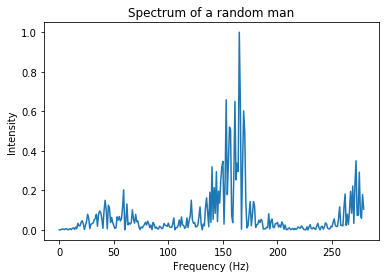

In [10]:
men_fouriers = get_freqs_of_everyone(men_samples)
women_fouriers = get_freqs_of_everyone(women_samples)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity')
plt.title('Spectrum of a random man')
plt.plot(men_fouriers[0][0], men_fouriers[0][1])
plt.show()

### Calculated features

I chose a set of features to be fed to the ML model:
* the **mean** of the frequencies (Hz), weighted by their intensity;
* the **weighted variance** of the frequencies;
* the **skewness**, which measures how the distribution of data is asymmetric compared to the mean;
* the **kurtosis** a.k.a the peakedness;
* the **scaling factor** used in normalization.

In [11]:
def get_features(frequencies, intensities):
    mean = np.average(frequencies, weights=intensities)
    std = np.sqrt(np.average((frequencies-mean)**2, weights=intensities))
    skewness = np.average(np.power(frequencies - mean, 3), weights=intensities) / np.power(std, 3)
    kurtosis = np.average(np.power(frequencies - mean, 4), weights=intensities) / np.power(std, 4)
    
    return np.array([mean, std, skewness, kurtosis])

def get_features_of_everyone(samples):
    data = [np.append(get_features(sample[0],sample[1]), sample[2]) 
            for sample in samples]
    return np.stack(data, axis=0)

In [12]:
men_features = get_features_of_everyone(men_fouriers)
women_features = get_features_of_everyone(women_fouriers)

print('Random man features:', men_features[0])

Random man features: [ 1.55092676e+02  6.51951934e+01 -7.11108331e-03  2.84821091e+00
  3.06899966e+01]


### Training and classification

Given the features values, we are going to train a ML model (KNN) with this data.

Before dealing with all the features, feature scaling it's applied. This is required to have better accuracy since we use the Euclidean distance in the KNN algorithm.

Since we don't have enough data to have a separated validation dataset in order to tune the hyperparameter, I choose to use k-fold Cross-Validation to avoid a biased estimation.

Furthermore, I set some constraints before choosing k:
* `k` must be even to avoid predictions equals to zero;
* choosing `k=1` it's a bad idea since it may lead to overfitting.

Last but not least, we calculate the accuracy of the model for every test set.

In [31]:
X = np.append(men_features, women_features, axis=0)
y = np.append(np.ones(np.shape(men_features)[0]), -1 * np.ones(np.shape(women_features)[0]))

number_splits = 10
kf = KFold(n_splits=number_splits, shuffle=True, random_state=4)
kf.get_n_splits(X)

accuracy_acc = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Data normalization
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std  = std_scale.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)

    accuracy = np.sum(np.sign(y_pred) == y_test) / np.size(y_test) * 100
    accuracy_acc += accuracy
    print('Accuracy: ', accuracy, '%')
    
print('AVG accuracy: ', accuracy_acc/number_splits, '%')

Accuracy:  100.0 %
Accuracy:  83.33333333333334 %
Accuracy:  100.0 %
Accuracy:  100.0 %
Accuracy:  83.33333333333334 %
Accuracy:  100.0 %
Accuracy:  100.0 %
Accuracy:  60.0 %
Accuracy:  80.0 %
Accuracy:  60.0 %
AVG accuracy:  86.66666666666667 %


## License
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
    <img alt="Creative Commons Licence" style="border-width:0; float:left; margin-right: 10px" src="https://i.creativecommons.org/l/by/4.0/80x15.png" />
</a>
This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.